In [1]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import tensorflow
import pickle
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, zero_one_loss, balanced_accuracy_score, average_precision_score

In [2]:
def calcular_error(y_test, y_pred):
    
    ## MEAN ABSOLUTE ERROR
    mae = MAE(y_test.flatten(), y_pred.flatten())

    ##MEAN SQUARE ERROR
    mse = MSE(y_test.flatten(), y_pred.flatten())

    ## root mean square error
    rmse = np.sqrt(mse)

    return mae, mse, rmse

In [3]:
def cargar_dataset(path_x, path_y):

    Y = np.load(path_y)
    Y_next = np.zeros((19287, 137, 157))

    # Obtenemos lluvias en tiempo t + 1 
    for i in range(Y_next.shape[0]):
        Y_next[i] = Y[i+1]
    Y = None

    # carga dataset x_test e y_test
    X = np.load(path_x)
    X_test = X[16395:19287, :, :, :]
    X = None
    Y_test =  Y_next[16395:, :, :]
    Y_next = None
        
    # Recorte para obtener 128x144
    X_test = X_test[:, :, 0:128, 0:144]
    Y_test = Y_test[:, 0:128, 0:144]
    Y_test = np.expand_dims(Y_test, axis=1)
    
    # Muevo el eje RGB al ultimo
    X_test = np.moveaxis(X_test, 1, 3)
    Y_test = np.moveaxis(Y_test, 1, 3)
    
    return X_test, Y_test

### opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) / loss=mae
### Presion: 700 mb / 100 epochs

In [4]:
path_x = "/opt/datos/dataset/gfs/wind/X_rain700.npy"
path_y = "/opt/datos/dataset/gfs/Y.npy"

X_test, Y_test = cargar_dataset(path_x, path_y) 
model = load_model("/opt/datos/entrenamientos/gfs/wind/05/model.h5")
y_pred = model.predict(X_test) #Unet

mae0, mse0, rmse0 = calcular_error(Y_test, y_pred)
print(f'MAE: {mae0}')
print(f'MSE: {mse0}')
print(f'RMSE: {rmse0}')

MAE: 0.2695359301278098
MSE: 1.1750986019923908
RMSE: 1.0840196501873898


### opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) / loss=mae
### Presion: 850 mb / 100 epochs

In [11]:
path_x = "/opt/datos/dataset/gfs/wind/X_rain850.npy"
path_y = "/opt/datos/dataset/gfs/Y.npy"

X_test_sin, Y_test_sin = cargar_dataset(path_x, path_y)
model = load_model("/opt/datos/entrenamientos/gfs/wind/06/model.h5")
y_pred_sin = model.predict(X_test_sin) 

mae1, mse1, rmse1 = calcular_error(Y_test_sin, y_pred_sin)
print(f'MAE: {mae1}')
print(f'MSE: {mse1}')
print(f'RMSE: {rmse1}')

MAE: 0.2587255057561211
MSE: 1.1303129430670253
RMSE: 1.0631617671206133


### opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) / loss=mae
### Presion: 850 mb / 100 epochs / Shuffle

In [4]:
path_x = "/opt/datos/dataset/gfs/wind/X_rain850.npy"
path_y = "/opt/datos/dataset/gfs/Y.npy"

X_test_s, Y_test_s = cargar_dataset(path_x, path_y)
model = load_model("/opt/datos/entrenamientos/gfs/wind/09/model.h5")
y_pred_s = model.predict(X_test_s)

mae2, mse2, rmse2 = calcular_error(Y_test_s, y_pred_s)
print(f'MAE: {mae2}')
print(f'MSE: {mse2}')
print(f'RMSE: {rmse2}')

MAE: 0.19511839046532903
MSE: 0.6045305576154372
RMSE: 0.7775156317498942


## Comparacion Errores

In [ ]:
mae0,mae1,mae2 = 0.2695359301278098, 0.2587255057561211, 0.19511839046532903
mse0,mse1,mse2 = 1.1750986019923908, 1.1303129430670253, 0.6045305576154372
rmse0,rmse1,rmse2 = 1.0840196501873898, 1.0631617671206133, 0.7775156317498942

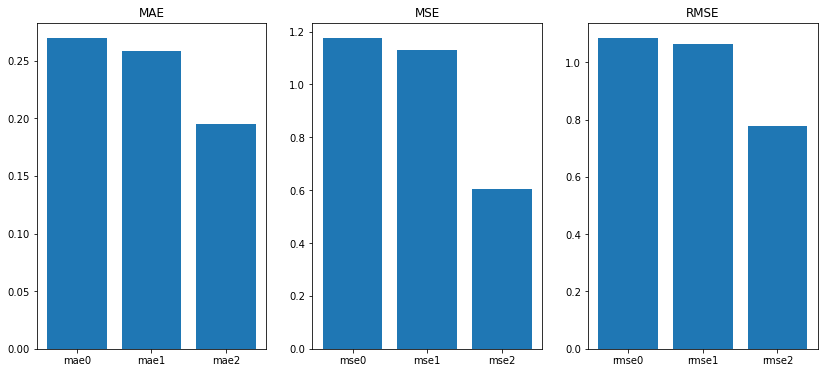

In [8]:
array_mae = {'mae0':mae0, 'mae1':mae1, 'mae2':mae2}
array_mse = {'mse0':mse0, 'mse1':mse1, 'mse2':mse2}
array_rmse = {'rmse0':rmse0, 'rmse1':rmse1, 'rmse2':rmse2}

plt.figure(figsize=(14,6))
plt.subplot(131), plt.bar(array_mae.keys(), array_mae.values()), plt.title('MAE')
plt.subplot(132), plt.bar(array_mse.keys(), array_mse.values()), plt.title('MSE')
plt.subplot(133), plt.bar(array_rmse.keys(), array_rmse.values()), plt.title('RMSE')
plt.show()

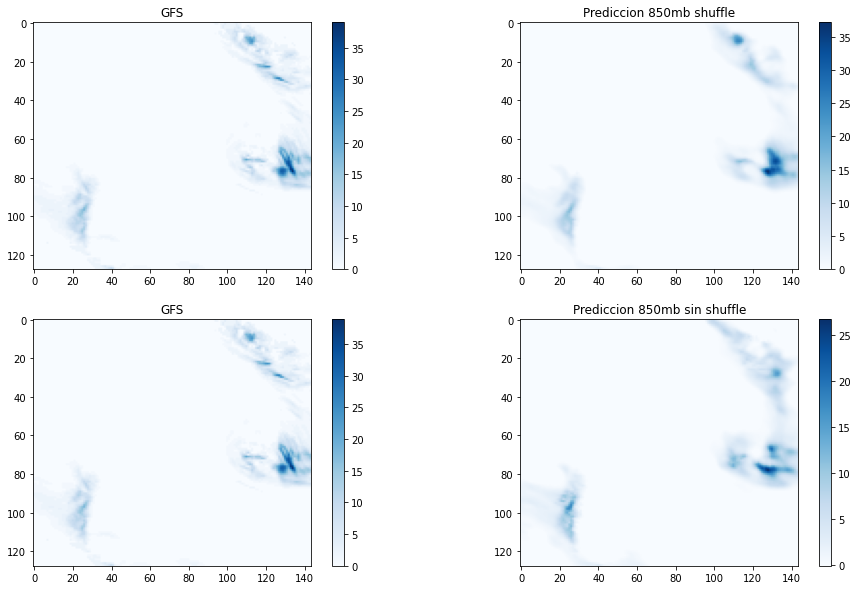

In [88]:
n = 270
plt.figure(figsize=(16,10))
plt.subplot(221), plt.imshow(Y_test_s[n], cmap='Blues'), plt.colorbar(), plt.title('GFS')
plt.subplot(222), plt.imshow(y_pred_s[n], cmap='Blues'), plt.colorbar(), plt.title('Prediccion 850mb shuffle')
plt.subplot(223), plt.imshow(Y_test_sin[n], cmap='Blues'), plt.colorbar(), plt.title('GFS')
plt.subplot(224), plt.imshow(y_pred_sin[n], cmap='Blues'), plt.colorbar(), plt.title('Prediccion 850mb sin shuffle')
plt.show()

## Errores con clases

In [108]:
def to_clases(xy):
    xy_clases = np.copy(xy)
    xy_clases = xy_clases.astype('uint8')
    
    xy_clases[(xy_clases >= 0) & (xy_clases < 2)] = 0
    xy_clases[(xy_clases >= 2) & (xy_clases < 10)] = 1
    xy_clases[(xy_clases >= 10) & (xy_clases < 20)] = 2
    xy_clases[(xy_clases >= 20) & (xy_clases < 30)] = 3
    xy_clases[(xy_clases >= 30)] = 4
    
    return xy_clases;

In [109]:
def mostrar_resultados(y_t_flat, y_p_flat):
    predije = ["0", "1", "2", "3", "4"]
    conf_matrix = confusion_matrix(y_t_flat, y_p_flat)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=predije, yticklabels=predije, annot=True, fmt="d", norm=LogNorm());
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_t_flat, y_p_flat))

### 850mb con shuffle

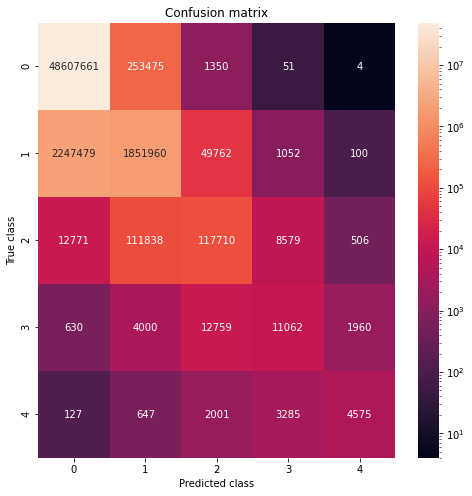

              precision    recall  f1-score   support

           0       0.96      0.99      0.97  48862541
           1       0.83      0.45      0.58   4150353
           2       0.64      0.47      0.54    251404
           3       0.46      0.36      0.41     30411
           4       0.64      0.43      0.51     10635

    accuracy                           0.95  53305344
   macro avg       0.71      0.54      0.60  53305344
weighted avg       0.94      0.95      0.94  53305344



In [110]:
y_test_clases = to_clases(Y_test_s)
y_test_flat = y_test_clases.flatten()

y_pred_clases = to_clases(y_pred_s)
y_pred_flat = y_pred_clases.flatten()

mostrar_resultados(y_test_flat, y_pred_flat)

### Comparación de imagenes clasificadas en clases.

In [111]:
a = to_clases(y_pred_s)
b = to_clases(Y_test_s)

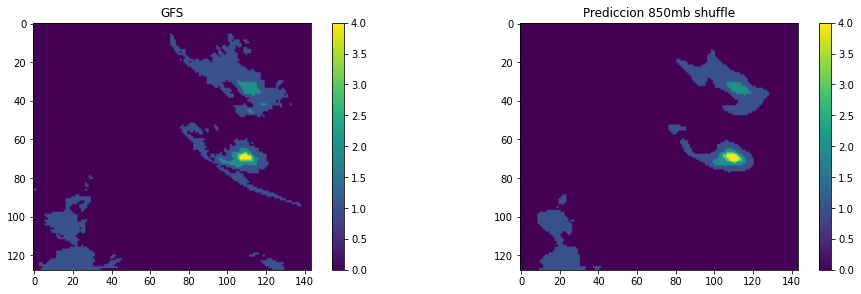

In [112]:
n = 264
plt.figure(figsize=(16,10))
plt.subplot(221), plt.imshow(b[n]), plt.colorbar(), plt.title('GFS')
plt.subplot(222), plt.imshow(a[n]), plt.colorbar(), plt.title('Prediccion 850mb shuffle')
plt.show()

## Comparacion pixel a pixel

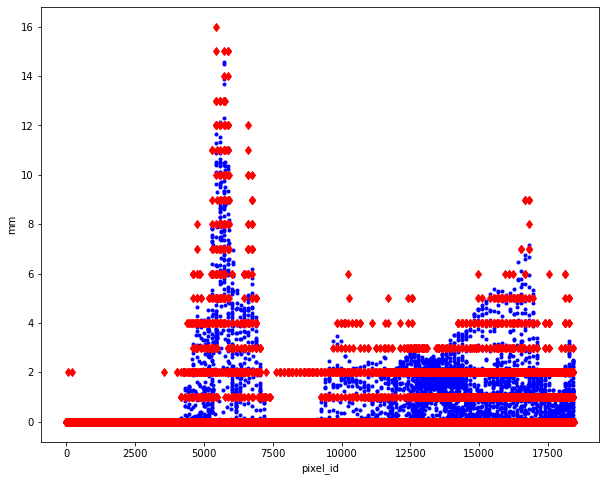

In [104]:
n=y_pred_s[0,:,:,0].flatten().shape[0]
i=297

plt.figure(figsize=(10,8))
plt.plot(range(n), y_pred_s[i,:,:,0].flatten(),'b.',range(n),Y_test_s[i,:,:,0].flatten(),'rd')
plt.ylabel('mm')
plt.xlabel('pixel_id')
plt.show()
#y_pred_s[0,:,:,0].flatten().shape

### Comparación GFS vs PREDICCIÓN

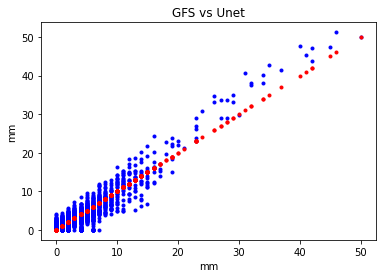

In [82]:
n=y_pred_s[0,:,:,0].flatten().shape[0]
i=264

plt.title('GFS vs Unet')
plt.plot(Y_test_s[i,:,:,0].flatten(), y_pred_s[i,:,:,0].flatten() ,'b.',Y_test_s[i,:,:,0].flatten(),Y_test_s[i,:,:,0].flatten(),'r.')
plt.ylabel('mm')
plt.xlabel('mm')
plt.show()